In [1]:
import re
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt 


nltk.download('wordnet')
nltk.download('punkt')

lemma = nltk.wordnet.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /Users/neko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/neko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Import stop words from the txt file
text_file = open("common_words.txt", "r")
common_words = text_file.read().split('\n')

In [3]:
# Choose top 500 words as stop words
stop_words = common_words[:500]

In [4]:
df = pd.read_csv('data.csv')
df.head()

,Category,Questions,Answers
0,Linear Regression,What are the assumptions required for linear r...,There are four assumptions associated with a l...
1,Statistics,What is collinearity? What is multicollinearit...,Collinearity is a linear association between t...
2,Linear Regression,What are the drawbacks of a linear model?\n,There are a couple of drawbacks of a linear mo...
3,Linear Regression,What are ridge and lasso regression and what a...,Both L1 and L2 regularization are methods used...
4,KNN,How does K-Nearest Neighbor work?,K-Nearest Neighbors is a classification techni...


In [5]:
# NLP cleaning function 
def nlp_process(text):
    
    # Case lowering 
    text = text.lower()
    # Replacing all special characters including numbers
    text = re.sub('[^A-Za-z]+',' ', text)
    # Tokenizing text into word list
    text = nltk.word_tokenize(text)
    # Removing stop words
    text = [word for word in text if word not in stop_words]
    # WordNet lemmatizing each tokenized word 
    text = [lemma.lemmatize(word) for word in text]
    # Joining words together 
    text = ' '.join(text)
    
    return text

In [6]:
# Cleaning up Questions and Answers
df['Questions'] = df['Questions'].apply(lambda x: nlp_process(x))
df['Answers'] = df['Answers'].apply(lambda x: nlp_process(x))
df

,Category,Questions,Answers
0,Linear Regression,assumption linear regression assumption violated,four assumption associated linear regression l...
1,Statistics,collinearity multicollinearity deal,collinearity linear association predictor mult...
2,Linear Regression,drawback linear,couple drawback linear linear hold strong assu...
3,Linear Regression,ridge lasso regression difference,regularization method reduce overfitting least...
4,KNN,nearest neighbor,nearest neighbor classification technique samp...
...,...,...,...
319,Neural Network,advantage disadvantage neural network,advantage entire rather database parallel proc...
320,Decision Trees,default method splitting decision tree,default method gini measure impurity particula...
321,"XGBoost, SVM",xgboost perform svm,xgboos ensemble method us tree mean improves r...
322,Neural Network,nlp purpose encoder decoder,encoder decoder generate output sequence input...


In [7]:
# A set of question types 
set(df.Category)

{'AdaBoost, Gradient Boost',
 'Decision Trees',
 'Decision Trees, Time Series',
 'EDA',
 'Gradient Boosting',
 'Gradient Boosting, Logistic Regression',
 'KMeans',
 'KMeans, KNN',
 'KMeans, Methodology',
 'KNN',
 'KNN, KMeans',
 'Linear Regression',
 'Linear Regression, Logistic Regression',
 'Logistic Regression',
 'Methodology',
 'Naive Bayes',
 'Neural Network',
 'Random Forest',
 'Random Forest, Gradient Boosting',
 'Random Forest, Naive Bayes',
 'Random Forest, SVM',
 'SVM',
 'Statistics',
 'Statistics ',
 'Time Series',
 'Time Series, Decision Trees',
 'XGBoost',
 'XGBoost, Gradient Boosting',
 'XGBoost, SVM'}

In [8]:
# Mapping types into EDA, Methodology, Statistics, Model 
mapping = {'Neural Network': 'Model', 'Linear Regression': 'Model', 'Decision Trees': 'Model', 'Naive Bayes': 'Model',
          'SVM': 'Model', 'Random Forest': 'Model', 'Logistic Regression': 'Model', 'Time Series': 'Model', 'KMeans': 'Model',
          'Gradient Boosting': 'Model', 'Linear Regression, Logistic Regression': 'Model', 'Random Forest, Gradient Boosting':'Model',
          'Random Forest, SVM':'Model', 'KMeans, KNN':'Model', 'XGBoost':'Model', 'Random Forest, Naive Bayes': 'Model', 'Gradient Boosting, Logistic Regression':'Model',
          'AdaBoost, Gradient Boost':'Model', 'KNN':'Model', 'Time Series, Decision Trees':'Model', 'XGBoost, Gradient Boosting':'Model',
          'Decision Trees, Time Series':'Model', 'XGBoost, SVM':'Model', 'KMeans, Methodology': 'Methodology', 'KNN, KMeans':'Model', 'Statistics ':'Statistics'}

df = df.replace({'Category': mapping})

In [9]:
df.Category.value_counts()

Model          133
Methodology     94
Statistics      67
EDA             30
Name: Category, dtype: int64

In [10]:
# Create dummy variables for the category column 
category = df['Category'].str.get_dummies()
category.columns

Index(['EDA', 'Methodology', 'Model', 'Statistics'], dtype='object')

In [11]:
# Define a dataframe data that combines df and category
data = category
data['Questions'] = df['Questions']
data['Answers'] = df['Answers']

In [12]:
# Analyzing top frquent 2-gram words in the interview questions of type Methodology with CountVectorizer
def counter(Q_A, category, data, n_gram_min, n_gram_max):
    data = data[data[category]==1]
    word_vectorizer = CountVectorizer(ngram_range=(n_gram_min,n_gram_max), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(data[Q_A])
    frequencies = sum(sparse_matrix).toarray()[0]
    return pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values('frequency', ascending=False)

counter('Questions', 'Methodology', data, 2, 2)

,frequency
machine learning,8
cross validation,4
gradient descent,3
unsupervised learning,3
collaborative filtering,3
...,...
evaluate binary,1
etc recommender,1
error versus,1
error case,1


In [13]:
# Analyzing top frquent 2-gram words in the interview questions of type Methodology with TFIDF Vectorizer
def tfidf_counter(Q_A, category, data, n_gram_min, n_gram_max):
    data = data[data[category]==1]
    vectorizer = TfidfVectorizer(ngram_range=(n_gram_min,n_gram_max), analyzer='word')
    sparse_matrix =  vectorizer.fit_transform(data[Q_A])
    frequencies = sum(sparse_matrix).toarray()[0]
    return pd.DataFrame(frequencies, index=vectorizer.get_feature_names(), columns=['frequency']).sort_values('frequency', ascending=False)

tfidf_counter('Questions', 'Methodology', data, 2, 2)

,frequency
machine learning,2.988614
cross validation,2.726845
collaborative filtering,2.518434
avoid overfitting,2.000000
unsupervised learning,1.563356
...,...
algorithm magic,0.185695
unfortunate miss,0.185695
model known,0.185695
benchmark score,0.185695


Cluster: EDA


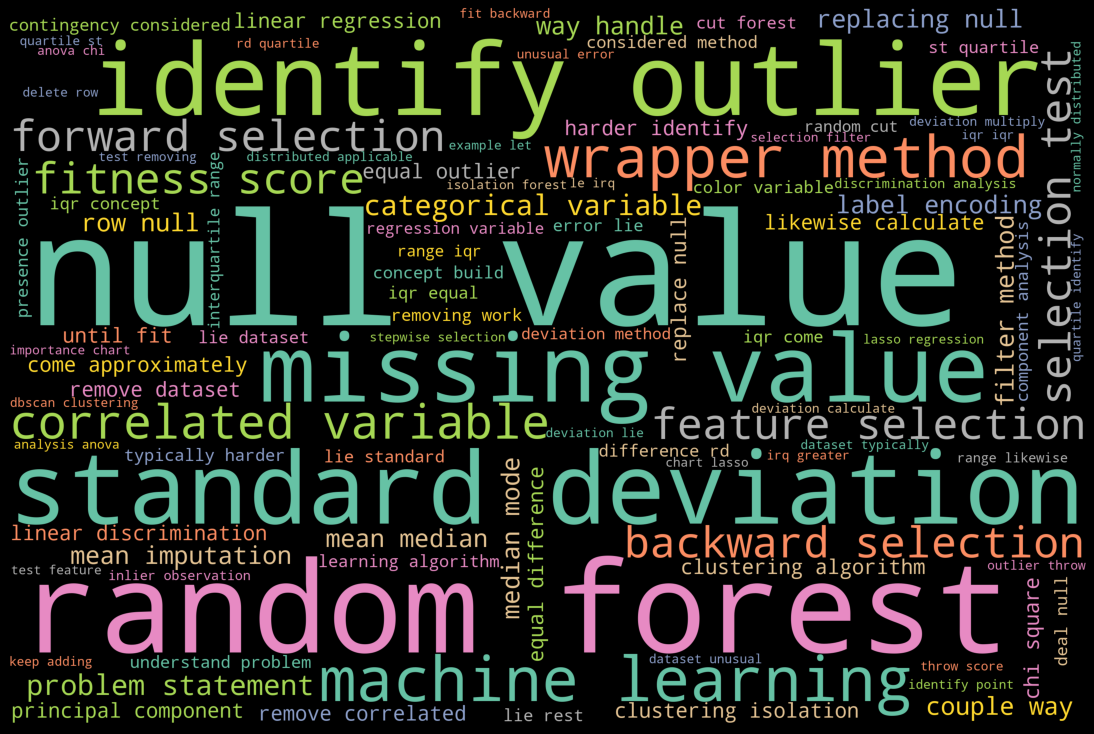

Cluster: Methodology


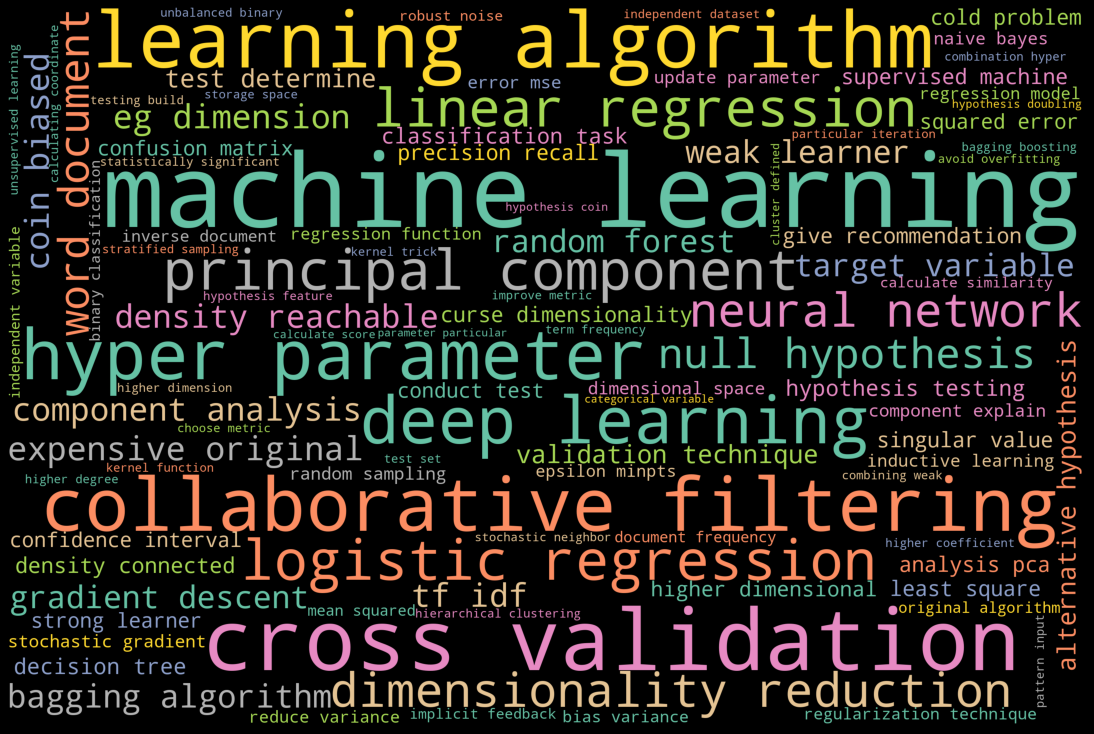

Cluster: Model


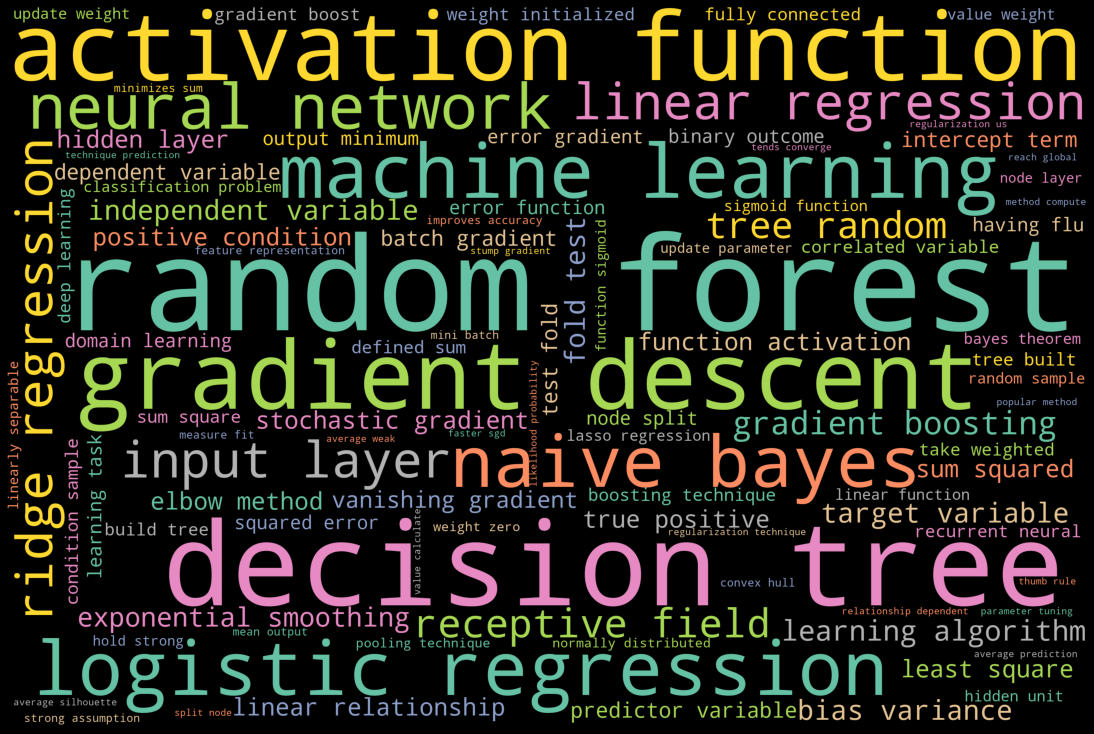

Cluster: Statistics


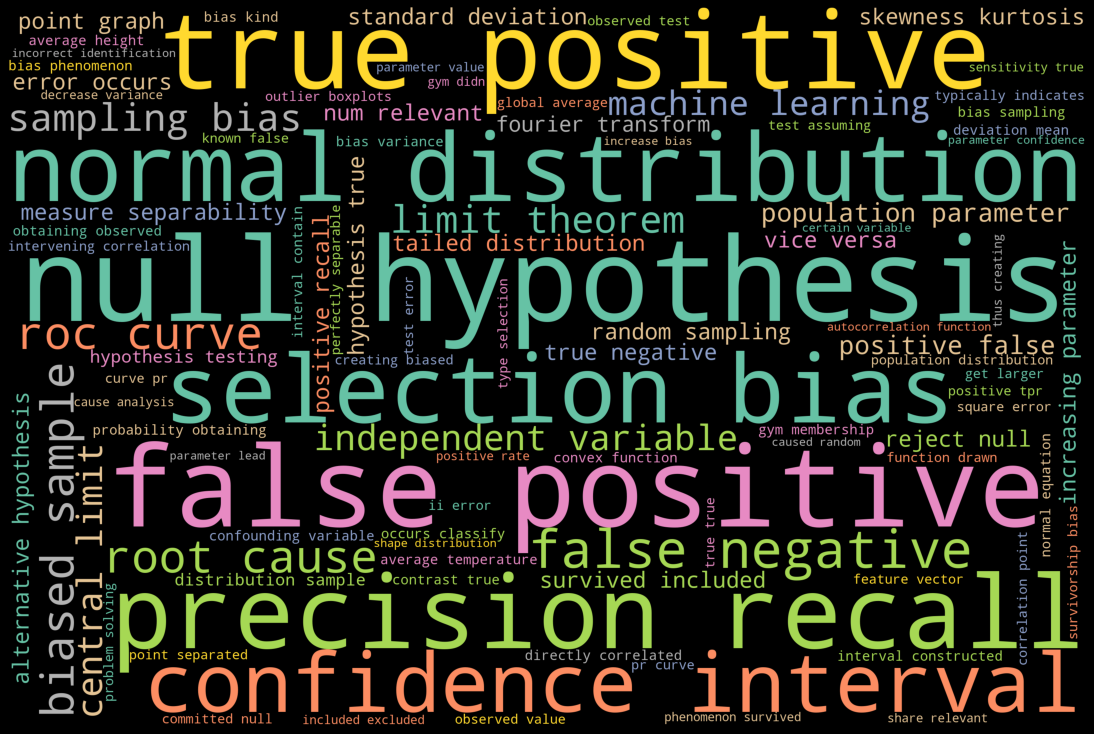

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [14]:
# Data visualization with bi-gram word clouds
for column in list(category.columns):
    cluster = data[data[column]==1]
    d = counter('Answers', column, cluster, 2, 2) # Select Questions or Answers 
    frequency = d.T.to_dict('records')[0]
    wordcloud = WordCloud(background_color='black',width=3000, height=2000, max_words=100, 
 random_state=1, colormap='Set2', collocations=False)
    wordcloud.generate_from_frequencies(frequencies=frequency)
    print('Cluster: {}'.format(column))
    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

In [15]:
df.head()

,Category,Questions,Answers
0,Model,assumption linear regression assumption violated,four assumption associated linear regression l...
1,Statistics,collinearity multicollinearity deal,collinearity linear association predictor mult...
2,Model,drawback linear,couple drawback linear linear hold strong assu...
3,Model,ridge lasso regression difference,regularization method reduce overfitting least...
4,Model,nearest neighbor,nearest neighbor classification technique samp...


In [16]:
# Split dataset
df_train, df_test = model_selection.train_test_split(df, test_size=0.2)

# Get target
y_train = df_train["Category"].values
y_test = df_test["Category"].values

In [17]:
# CountVectorizer for modeling 
vectorizer = feature_extraction.text.CountVectorizer(max_features=300, ngram_range=(1,2))

# Tf-Idf Vectorizer for modeling 
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=300, ngram_range=(1,2))

In [18]:
# Fit and transform the Vectorizer based on X_train
corpus = df_train['Questions']

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)

In [19]:
y = df_train['Category']
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
df_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {'Feature':X_names, 'Score':1-p, 'Category':cat}))
    df_features = df_features.sort_values(['Category','Score'], 
                    ascending=[True,False])
    df_features = df_features[df_features['Score']>p_value_limit]
X_names = df_features['Feature'].unique().tolist()

In [20]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(df_features[df_features['Category']==cat]))
    print("  . top features:", ",".join(
df_features[df_features['Category']==cat]['Feature'].values[:30]))
    print(" ")

# EDA:
  . selected features: 29
  . top features: feature,feature selection,missing,outlier,selection,dataset,encoding,imputation,inlier,method variable,might screen,screen,selection method,method,value,might,variable,explain,give,always,categorical,categorical variable,determine,doesn,handle,missing value,several,solve,true
 
# Methodology:
  . selected features: 56
  . top features: learning,machine,machine learning,predict,bought,result,approach,appropriate,bucket,learning algorithm,overfitting,recommender,test,algorithm,tree,linear,amazon,amazon result,avoid,avoid overfitting,bought bought,bought recommendation,cold,cold problem,collaborative,collaborative filtering,delivery,etc,filtering,gender
 
# Model:
  . selected features: 39
  . top features: tree,linear,neural,decision,decision tree,naive,regression,forest,random forest,bayes,cnn,gradient boosting,linear regression,weight,naive bayes,gradient,test,assumption,layer,net,neural net,pooling,random,example,false,given,svm,activ

In [21]:
# Fit and transform the Vectorizer based on the feature selection results X_names 
vectorizer = feature_extraction.text.CountVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)

# Testing ML models are Naive Bayes, Random Forest and Decision Trees 
NB_Classifier = naive_bayes.MultinomialNB()
RForest_Classifier = RandomForestClassifier()
DTree_Classifier = DecisionTreeClassifier()

# NB_Classifier Pipeline with CountVectorizer 
NB_Pipeline = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", NB_Classifier)])

# RForest_Classifier Pipeline with CountVectorizer 
RForest_Pipeline = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", RForest_Classifier)])

# DTree_Classifier Pipeline with CountVectorizer 
DTree_Pipeline = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", DTree_Classifier)])

In [22]:
def model_plot(pipeline):
    # train classifier
    pipeline["classifier"].fit(X_train, y_train)

    # test
    X_test = df_test.Questions.values
    predicted = pipeline.predict(X_test)
    predicted_prob = pipeline.predict_proba(X_test)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, predicted)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="BuPu");  

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['EDA', 'Method', 'Model', 'Statistics']); ax.yaxis.set_ticklabels(['EDA', 'Method', 'Model', 'Statistics'])

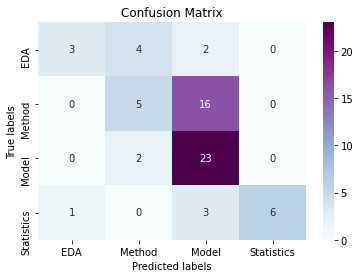

In [23]:
model_plot(NB_Pipeline)

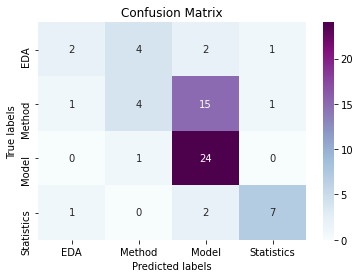

In [24]:
model_plot(RForest_Pipeline)

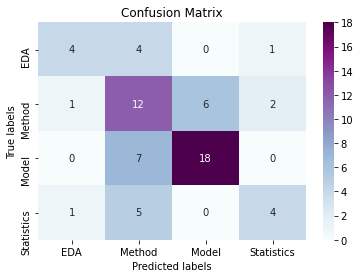

In [25]:
model_plot(DTree_Pipeline)